In [1]:
import time
import math
import copy
import torch
import random
import logging
import warnings
import datetime

import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as opt
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn import linear_model
from torch.autograd import grad
from torch.autograd.functional import vhp
from data_processing import get_data_adult
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score

plt.rcParams['figure.dpi'] = 300
warnings.filterwarnings("ignore")

E = math.e

### Utility Functions

In [2]:
def graph(data, title, x_label, y_label, labels):
    sns.set(font_scale=1)

    ticks = np.arange(0, len(data[2]), step=1)
    plt.xticks(ticks=ticks, labels=data[2], rotation='vertical')
    
    plt.plot(data[0], 'b-', linewidth=2.0, label=labels[0])
    plt.plot(data[1], 'r-', linewidth=2.0, label=labels[1])
    plt.plot([a_i - b_i for a_i, b_i in zip(data[0], data[1])], 'k', linewidth=2.0, label='difference')
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [3]:
 class CreateData(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.targets[idx]

        return out_data, out_label

### Randomized Response

In [4]:
def randomize_resp(label, epsilon):

    probability = float(E ** epsilon) / float(1 + (E ** epsilon))
    
    if label == 0:
        new_label = np.random.choice([0,1], p=[probability, 1-probability])
    else:
        new_label = np.random.choice([0,1], p=[1-probability, probability])

    return new_label

### Models

In [5]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, num_features, weight_decay, device):
        super(LogisticRegression, self).__init__()

        self.wd = torch.FloatTensor([weight_decay]).to(device)
        self.w = torch.nn.Parameter(torch.zeros([num_features], requires_grad=True))

    def forward(self, x):
        logits = torch.matmul(x, torch.reshape(self.w, [-1, 1]))

        return logits
    
    def loss(self, logits, y):
        preds = torch.sigmoid(logits)
        loss = -torch.mean(y * log_clip(preds) + (1 - y) * log_clip(1 - preds))

        return loss

In [6]:
def log_clip(x):
    return torch.log(torch.clamp(x, 1e-10, None))

### Influence Calculation Functions


In [7]:
def calc_influence_single(model, epsilon, train_data, test_data, device, rec_depth, r, damp, scale, s_test_vec):
    
    if s_test_vec is None:
        x_test, y_test = test_data[1], test_data[2]
        x_test = test_data[0].collate_fn([x_test])
        y_test = test_data[0].collate_fn([y_test])
        
        est_hess_inv = inv_hess(model, [train_data[1], train_data[2]], device, rec_depth, r)
        
        grad_test = grad_z([x_test, y_test], model, device)
   
        s_test_vec = grad_test[0] * torch.from_numpy(est_hess_inv).type(torch.FloatTensor).to(device)
        
    # Calculate the influence function
    train_dataset_size = len(train_data[0].dataset)
    y_perts = []

    for i, y_ in enumerate(train_data[2]):
        y_pert = randomize_resp(y_, epsilon)
        y_perts.append(y_pert)

    time_a = datetime.datetime.now()

    grad_z_vec = grad_training([train_data[1], train_data[2]], y_perts, model, device)

    time_b = datetime.datetime.now()
    time_delta = time_b - time_a
    logging.info(f"Time for grad_z iter:" f" {time_delta.total_seconds() * 1000}")

    with torch.no_grad():
        influence = sum([torch.sum(k * j).data for k, j in zip(grad_z_vec, s_test_vec)])

    return influence.cpu(), y_perts, s_test_vec

In [8]:
def inv_hess(model, train_data, device, rec_depth, r):

    H_inv = []
    
    hessian_loader = [train_data[0], train_data[1]]
    
    i_hess = np.zeros([len(model.w), len(model.w)])#np.identity(len(model.w))
    
    v = logistic_batch_grad(hessian_loader, model, device)
    
    for i in range(r):
        inv_hess = v[0].detach().cpu().numpy() #np.identity(len(model))
        
        for j in range(rec_depth):
            rand_index = random.sample(range(len(hessian_loader[0])), 1)
            
            rand_point = [hessian_loader[0][rand_index], hessian_loader[1][rand_index]]
            
            inv_hess = np.add(inv_hess, logistic_batch_hess_full(rand_point, v[0].detach().cpu().numpy()))
        
        H_inv.append(inv_hess)

    with torch.no_grad():
        for i in range(r):
            i_hess = np.add(i_hess, H_inv[i])
        
        i_hess = i_hess / r

    return i_hess

In [9]:
def logistic_batch_hess_full(rand_point, model):
    batch_hess = np.zeros((len(model), len(model)))
    
    batch_hess += np.outer(logistic_indiv_hess(rand_point, model), logistic_indiv_hess(rand_point, model))
    
    return np.add(batch_hess, 2*1e-4*np.identity(len(model)))

In [10]:
def logistic_indiv_hess(rand_point, model):
    
    v = -1.0*rand_point[1]*np.dot(np.atleast_2d(model), rand_point[0].T)
    
    return (rand_point[1])*((math.pow(np.exp(v),0.5))/(np.exp(v)+1))*rand_point[0]

In [11]:
def logistic_batch_grad(hessian_loader, model, device):
    prediction = model(torch.from_numpy(hessian_loader[0]).type(torch.FloatTensor).to(device))
    loss = calc_loss(prediction, torch.from_numpy(hessian_loader[1]).type(torch.FloatTensor).to(device))
    
    return grad(loss, model.parameters())       

In [12]:
def grad_z(test_data, model, device):

    model.eval()

    test_data_features = test_data[0]
    test_data_labels = test_data[1]

    logits = model(test_data_features)
    prediction = torch.sigmoid(logits)
    loss = -torch.mean(test_data_labels * log_clip(prediction) + (1 - test_data_labels) * log_clip(1 - prediction))
    
    return grad(loss, model.parameters())

In [13]:
def grad_training(train_data, y_perts, model, device):
    
    model.eval()

    train_data_features = torch.FloatTensor(train_data[0]).to(device)
    train_data_labels = torch.FloatTensor(train_data[1]).to(device)
    train_pert_data_labels = torch.FloatTensor(y_perts).to(device)

    logits = model(train_data_features)
    prediction = torch.sigmoid(logits)
    orig_loss = -torch.mean(train_data_labels * log_clip(prediction) + (1 - train_data_labels) * log_clip(1 - prediction))
    pert_loss = -torch.mean(train_pert_data_labels * log_clip(prediction) + (1 - train_pert_data_labels) * log_clip(1 - prediction))
    
    loss = (pert_loss -  orig_loss)
    
    return grad(loss, model.parameters())

In [14]:
def calc_loss(logits, labels):
    preds = torch.sigmoid(logits)
    loss = -torch.mean(labels * log_clip(preds) + (1 - labels) * log_clip(1 - preds))

    return loss

In [15]:
def make_functional(model):
    orig_params = tuple(model.parameters())

    names = []

    for name, p in list(model.named_parameters()):
        del_attr(model, name.split("."))
        names.append(name)

    return orig_params, names

In [16]:
def del_attr(obj, names):
    if len(names) == 1:
        delattr(obj, names[0])
    else:
        del_attr(getattr(obj, names[0]), names[1:])

In [17]:
def set_attr(obj, names, val):
    if len(names) == 1:
        setattr(obj, names[0], val)
    else:
        set_attr(getattr(obj, names[0]), names[1:], val)

In [18]:
def load_weights(model, names, params, as_params=False):
    for name, p in zip(names, params):
        if not as_params:
            set_attr(model, name.split("."), p)
        else:
            set_attr(model, name.split("."), torch.nn.Parameter(p))

### Perform Influence Calculation and LOO

In [19]:
class TestLeaveOneOut():
    def test_leave_one_out(self, epsilon, weight_decay, rec_depth, r, scale, damp, s_test_vec):

        num_features, train_data, test_data = get_data_adult()

        device = 'cuda:3' if torch.cuda.is_available() else 'cpu'

        train_sample_num = len(train_data[1])

        train_dataset = CreateData(train_data[0], train_data[1])
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

        # prepare sklearn model to train w
        C = 1.0 / (train_sample_num * weight_decay)
        sklearn_model = linear_model.LogisticRegression(C=C, solver='lbfgs', tol=1e-8, fit_intercept=False)

        # prepare pytorch model to compute influence function
        torch_model = LogisticRegression(num_features, weight_decay, device)

        # train
        sklearn_model.fit(train_data[0], train_data[1])
        pred_logr = sklearn_model.predict(test_data[0])
        score = accuracy_score(test_data[1], pred_logr)
        print('')
        print(f'lbfgs training took {sklearn_model.n_iter_} iter. Accuracy: {score:0.3f}'  )

        # assign W into pytorch model
        w_opt = sklearn_model.coef_.ravel()
        with torch.no_grad():
            torch_model.w = torch.nn.Parameter(
                torch.tensor(w_opt, dtype=torch.float)
            )
        torch_model = torch_model.to(device)
        
        # calculate original loss
        x_test_input = torch.FloatTensor(test_data[0][12345]).to(device)
        y_test_input = torch.LongTensor(test_data[1])[12345].to(device)

        test_dataset = CreateData(test_data[0][12345], test_data[1][12345])
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
      
        test_loss_ori = torch_model.loss(torch_model(x_test_input), y_test_input).detach().cpu().numpy()

        loss_diff_approx, train_data_perts, s_test_vec = calc_influence_single(torch_model, epsilon, [train_loader, train_data[0], train_data[1]], [test_loader, x_test_input, y_test_input], device, rec_depth, r, damp, scale, s_test_vec)
        
        loss_diff_approx = - torch.FloatTensor(loss_diff_approx).cpu().numpy()

        # retrain
        sklearn_model_pert = linear_model.LogisticRegression(C=C, fit_intercept=False, tol=1e-8, solver='lbfgs')
        sklearn_model_pert.fit(train_data[0], train_data_perts)
        
        pred_logr = sklearn_model_pert.predict(test_data[0])
        score = accuracy_score(test_data[1], pred_logr)
        print('')
        print(f'Perturbation lbfgs training took {sklearn_model_pert.n_iter_} iter. Accuracy: {score:0.3f}'  )
       
        w_retrain = sklearn_model_pert.coef_.T.ravel()
        with torch.no_grad():
            torch_model.w = torch.nn.Parameter(
                torch.tensor(w_retrain, dtype=torch.float)
            )

        torch_model = torch_model.to(device)

        # get retrain loss
        test_loss_retrain = torch_model.loss(torch_model(x_test_input), y_test_input).detach().cpu().numpy()

        # get true loss diff
        loss_diff_true = test_loss_retrain - test_loss_ori
        
        est_loss_diff = loss_diff_approx
        avg_loss_diff = loss_diff_true
        print('')
        print('Real avg. loss diff: ', avg_loss_diff, 'Est. avg. loss diff: ', est_loss_diff)
        
        return avg_loss_diff, est_loss_diff, s_test_vec

In [20]:
def visualize_result(actual_loss_diff, estimated_loss_diff):
    r2_s = r2_score(actual_loss_diff, estimated_loss_diff)

    max_abs = np.max([np.abs(actual_loss_diff), np.abs(estimated_loss_diff)])
    min_, max_ = -max_abs * 1.1, max_abs * 1.1
    plt.rcParams['figure.figsize'] = 6, 5
    plt.scatter(actual_loss_diff, estimated_loss_diff, zorder=2, s=10)
    plt.title('Loss diff Pert.')
    plt.xlabel('Actual loss diff')
    plt.ylabel('Estimated loss diff')
    range_ = [min_, max_]
    plt.plot(range_, range_, 'k-', alpha=0.2, zorder=1)
    text = 'MAE = {:.03}\nR2 score = {:.03}'.format(mean_absolute_error(actual_loss_diff, estimated_loss_diff),
                                                    r2_s)
    plt.text(max_abs, -max_abs, text, verticalalignment='bottom', horizontalalignment='right')
    plt.xlim(min_, max_)
    plt.ylim(min_, max_)

    plt.savefig("result.png")

    return r2_s

In [21]:
epsilons = [.001, .005, .01, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1, 5, 10]

all_avg = []
all_est = []

weight_decay = 0.01
rec_depth = 5350
r = 5
scale = 10
damp = 0.01 
rounds = 5

LOO = TestLeaveOneOut()

s_test_vec = None

for ro in range(rounds):
    avg_losses = []
    est_losses = []
    for e in epsilons:
        print('Working on epsilon: ', e)
        avg_loss_diff, est_loss_diff, s_test_vec = LOO.test_leave_one_out(e, weight_decay, rec_depth, r, scale, damp, s_test_vec)
        avg_losses.append(avg_loss_diff)
        est_losses.append(est_loss_diff)
    all_avg.append(avg_losses)
    all_est.append(est_losses)
    
final_real = [0 for x in range(len(epsilons))]
final_est = [0 for x in range(len(epsilons))]

for i in range(len(final_real)):
    for j in range(len(all_avg)):
        final_real[i] = final_real[i] + all_avg[j][i]
        final_est[i] = final_est[i] + all_est[j][i]



Working on epsilon:  0.001

lbfgs training took [21] iter. Accuracy: 0.868

Perturbation lbfgs training took [15] iter. Accuracy: 0.438

Real avg. loss diff:  0.6306965 Est. avg. loss diff:  0.3485169
Working on epsilon:  0.005

lbfgs training took [21] iter. Accuracy: 0.868

Perturbation lbfgs training took [14] iter. Accuracy: 0.603

Real avg. loss diff:  0.64069843 Est. avg. loss diff:  0.3420849
Working on epsilon:  0.01

lbfgs training took [21] iter. Accuracy: 0.868

Perturbation lbfgs training took [15] iter. Accuracy: 0.352

Real avg. loss diff:  0.68691605 Est. avg. loss diff:  0.35009795
Working on epsilon:  0.05

lbfgs training took [21] iter. Accuracy: 0.868

Perturbation lbfgs training took [16] iter. Accuracy: 0.646

Real avg. loss diff:  0.5910747 Est. avg. loss diff:  0.34201306
Working on epsilon:  0.1

lbfgs training took [21] iter. Accuracy: 0.868

Perturbation lbfgs training took [18] iter. Accuracy: 0.815

Real avg. loss diff:  0.58118737 Est. avg. loss diff:  0.32


lbfgs training took [21] iter. Accuracy: 0.868

Perturbation lbfgs training took [16] iter. Accuracy: 0.868

Real avg. loss diff:  0.34455806 Est. avg. loss diff:  0.23083548
Working on epsilon:  0.75

lbfgs training took [21] iter. Accuracy: 0.868

Perturbation lbfgs training took [17] iter. Accuracy: 0.868

Real avg. loss diff:  0.3510607 Est. avg. loss diff:  0.22206774
Working on epsilon:  0.8

lbfgs training took [21] iter. Accuracy: 0.868

Perturbation lbfgs training took [14] iter. Accuracy: 0.868

Real avg. loss diff:  0.33211684 Est. avg. loss diff:  0.21258129
Working on epsilon:  0.85

lbfgs training took [21] iter. Accuracy: 0.868

Perturbation lbfgs training took [17] iter. Accuracy: 0.868

Real avg. loss diff:  0.30381787 Est. avg. loss diff:  0.20862871
Working on epsilon:  0.9

lbfgs training took [21] iter. Accuracy: 0.868

Perturbation lbfgs training took [15] iter. Accuracy: 0.868

Real avg. loss diff:  0.3156594 Est. avg. loss diff:  0.2044245
Working on epsilon:  


lbfgs training took [21] iter. Accuracy: 0.868

Perturbation lbfgs training took [18] iter. Accuracy: 0.860

Real avg. loss diff:  0.5590012 Est. avg. loss diff:  0.30521733
Working on epsilon:  0.3

lbfgs training took [21] iter. Accuracy: 0.868

Perturbation lbfgs training took [18] iter. Accuracy: 0.868

Real avg. loss diff:  0.4868927 Est. avg. loss diff:  0.29195797
Working on epsilon:  0.35

lbfgs training took [21] iter. Accuracy: 0.868

Perturbation lbfgs training took [18] iter. Accuracy: 0.866

Real avg. loss diff:  0.44915158 Est. avg. loss diff:  0.28796926
Working on epsilon:  0.4

lbfgs training took [21] iter. Accuracy: 0.868

Perturbation lbfgs training took [18] iter. Accuracy: 0.868

Real avg. loss diff:  0.4805448 Est. avg. loss diff:  0.282256
Working on epsilon:  0.45

lbfgs training took [21] iter. Accuracy: 0.868

Perturbation lbfgs training took [18] iter. Accuracy: 0.867

Real avg. loss diff:  0.40647203 Est. avg. loss diff:  0.26906848
Working on epsilon:  0.


lbfgs training took [21] iter. Accuracy: 0.868

Perturbation lbfgs training took [20] iter. Accuracy: 0.868

Real avg. loss diff:  0.005688742 Est. avg. loss diff:  0.0045275954
Working on epsilon:  10

lbfgs training took [21] iter. Accuracy: 0.868

Perturbation lbfgs training took [21] iter. Accuracy: 0.868

Real avg. loss diff:  -2.9888004e-05 Est. avg. loss diff:  3.593541e-05


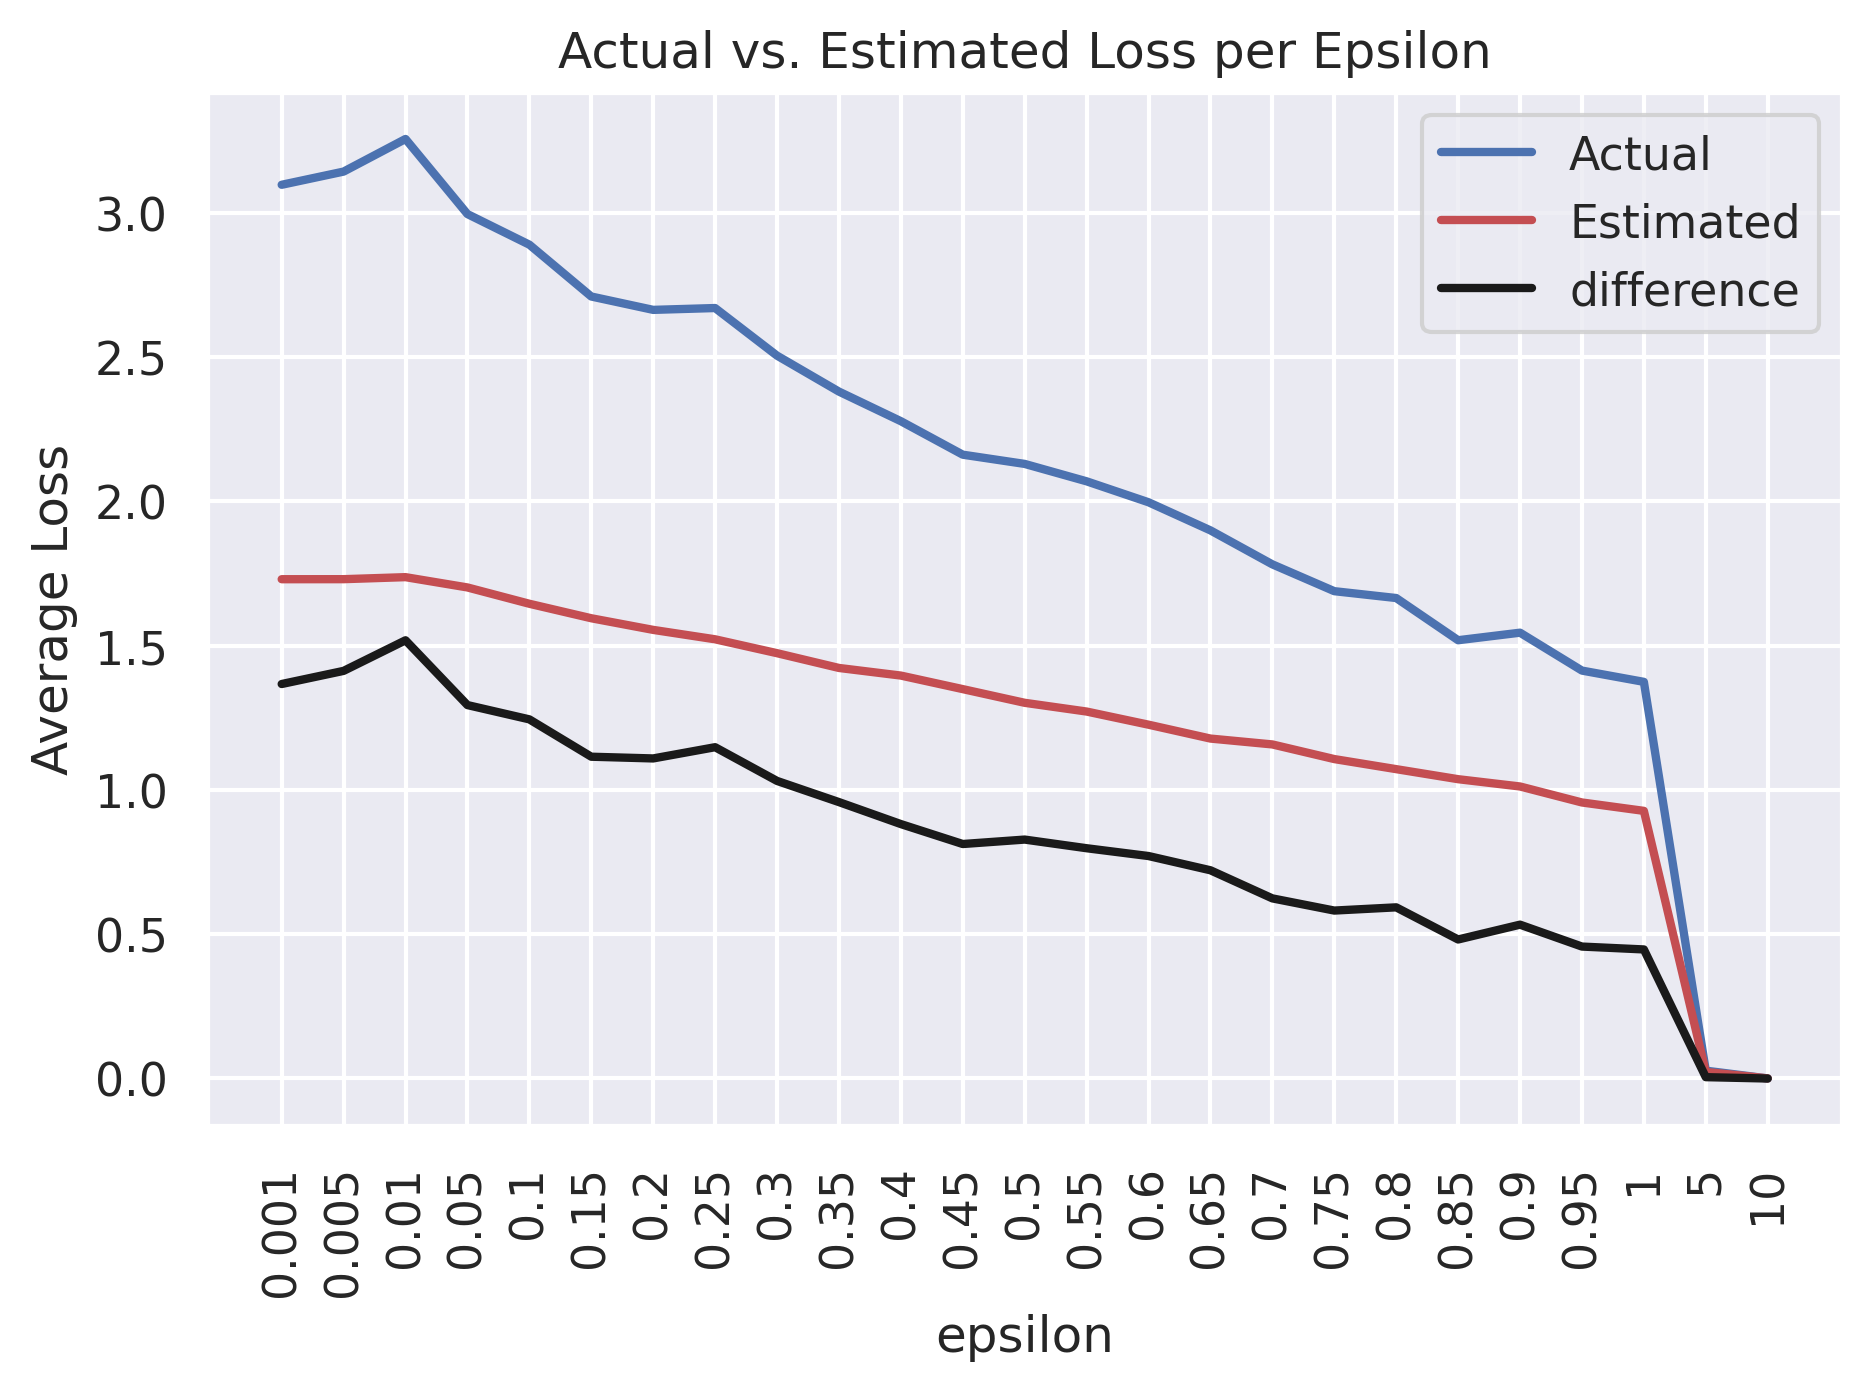

In [22]:
graph([final_real, final_est, epsilons], 'Actual vs. Estimated Loss per Epsilon', 'epsilon', 'Average Loss', ['Actual', 'Estimated'])

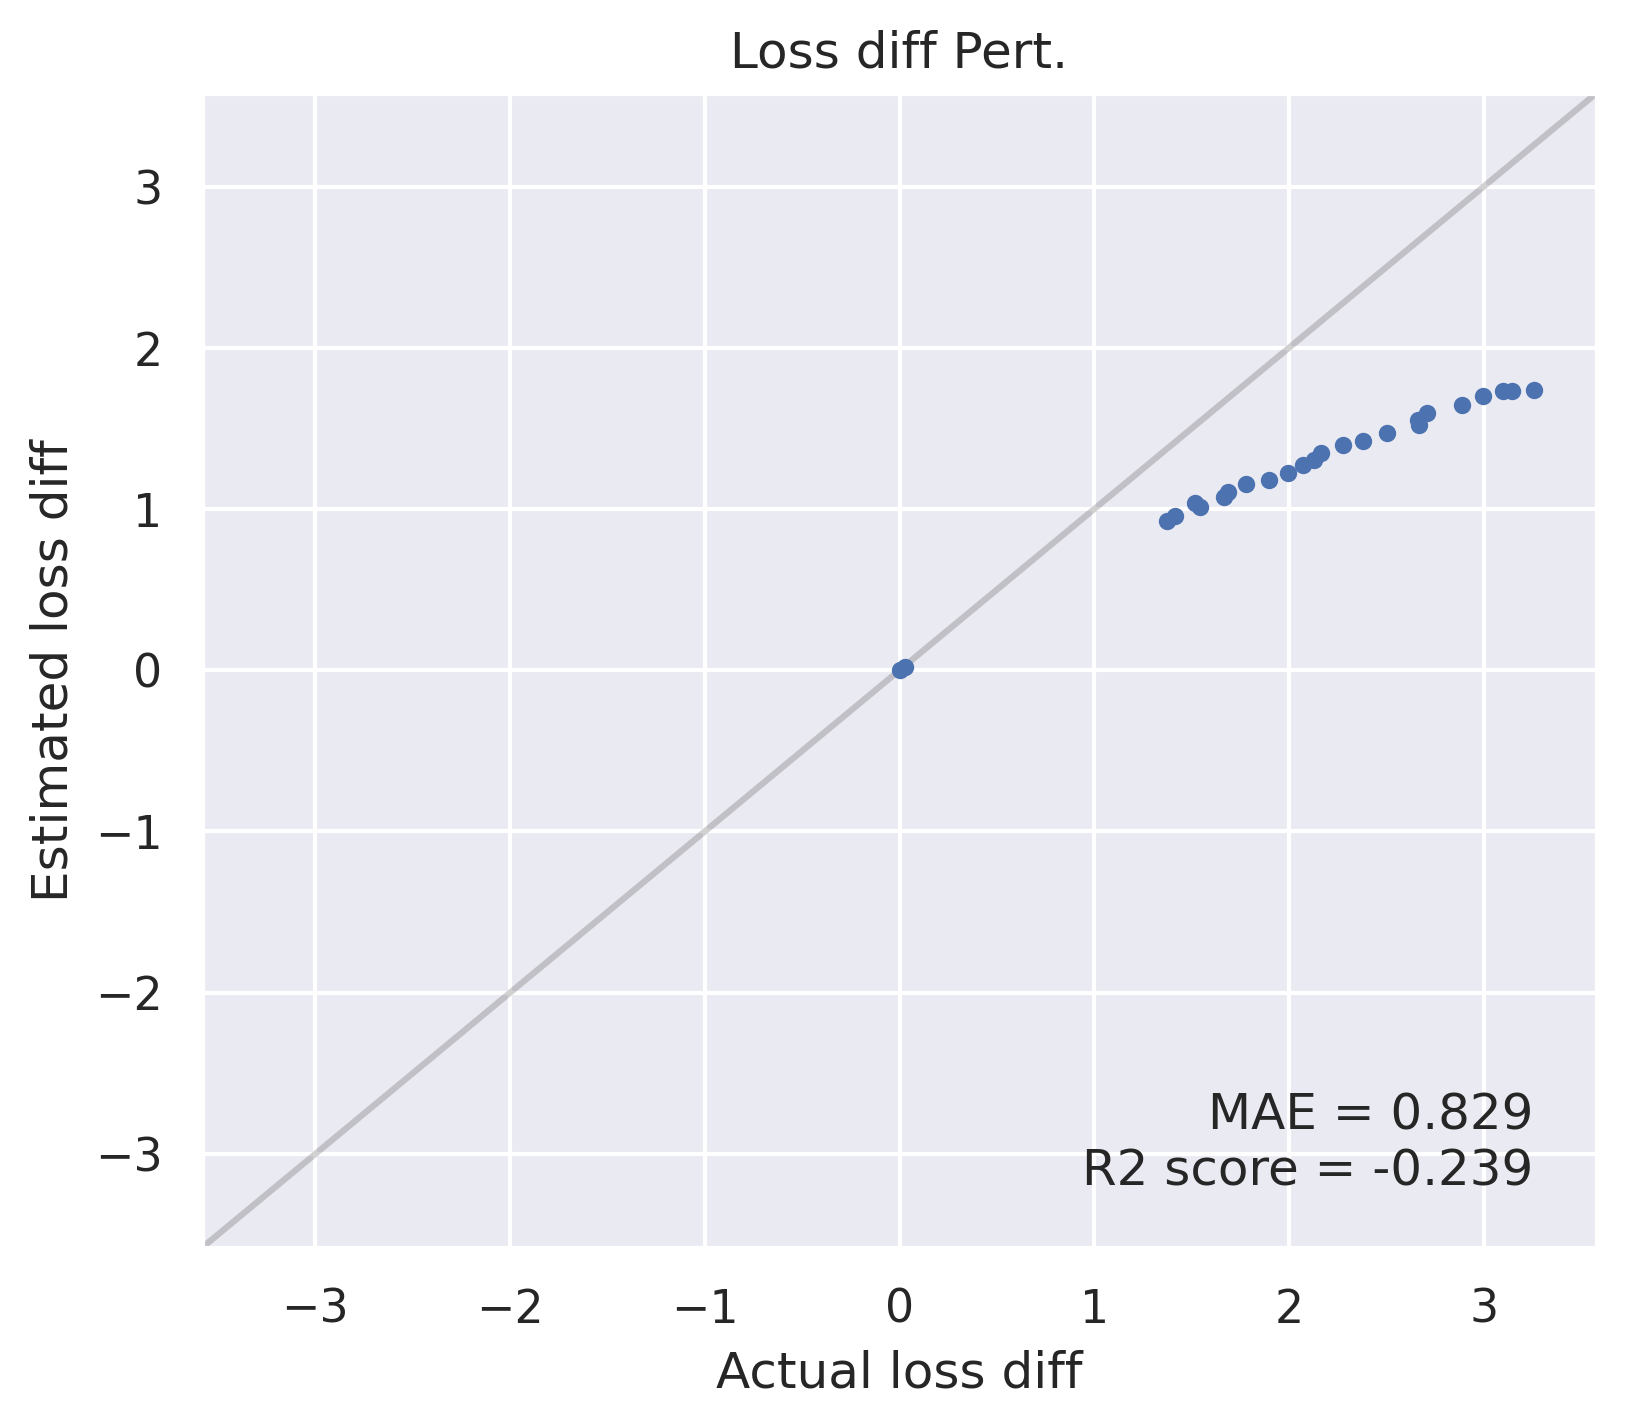

In [23]:
r2_s = visualize_result(final_real, final_est)